# Preprocessing

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
import random

from collections import defaultdict

In [2]:
DATA_DIR = "/home/vivianea/projects/BrainInnov/data/npy_3D_splitted"
SPLIT = "train"  # or "val", "test"
NUM_SAMPLES = 2

In [3]:
index_path = os.path.join(DATA_DIR, f"{SPLIT}_index.csv")
images_path = os.path.join(DATA_DIR, SPLIT)

In [4]:
# --- Load index ---
samples = []
with open(index_path, newline="") as f:
    reader = csv.DictReader(f)
    for row in reader:
        samples.append((row["filename"], int(row["label"])))

# --- Pick random samples ---
random_samples = random.sample(samples, min(NUM_SAMPLES, len(samples)))




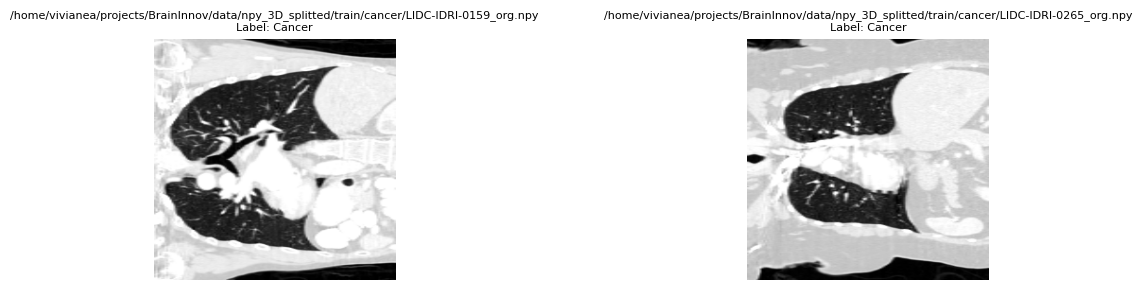

In [5]:
# --- Plot central slices from 3D volumes ---
fig, axes = plt.subplots(1, NUM_SAMPLES, figsize=(15, 3))
if NUM_SAMPLES == 1:
    axes = [axes]

for ax, (filename, label) in zip(axes, random_samples):
    img_path = os.path.join(images_path, filename)
    vol = np.load(img_path)  # Shape: (D, H, W)
    
    
    if vol.ndim == 4:
        vol = vol[0]
    center_slice = vol.shape[0] // 2
    img = vol[center_slice, :, :]  # Get the central axial slice

    ax.imshow(img, cmap="gray")
    ax.set_title(f"{filename}\nLabel: {'Cancer' if label == 1 else 'Non-cancer'}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [6]:
def debug_show_middle_slice(vol):
    mid = vol.shape[0] // 2
    plt.imshow(vol[:, :, mid], cmap="gray")
    plt.title("Middle slice of volume")
    plt.axis("off")
    plt.show()

In [7]:
# --- Configuration ---
SPLITS = ["train", "val", "test"]

def extract_patient_id(filename):
    # Extracts patient ID assuming filename format: "LIDC-IDRI-XXXX_sliceX.npy" or "LIDC-IDRI-XXXX_X_augY.npy"
    return filename.split('_')[-1]

In [8]:
for split in SPLITS:
    index_path = os.path.join(DATA_DIR, f"{split}_index.csv")
    summary = defaultdict(list)  # label -> [patient_ids]

    with open(index_path, newline="") as f:
        reader = csv.DictReader(f)
        for row in reader:
            label = int(row["label"])
            label_str = "cancer" if label == 1 else "non-cancer"
            patient_id = extract_patient_id(row["patient_id"])
            summary[label_str].append(patient_id)

    # Count and deduplicate
    stat_path = os.path.join(DATA_DIR, f"{split}_summary.csv")
    with open(stat_path, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["Class", "Num Samples", "Num Unique Patients"])
        for cls, patients in summary.items():
            writer.writerow([cls, len(patients), len(set(patients))])

    print(f"[✓] Saved summary for {split} to {stat_path}")

[✓] Saved summary for train to /home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train_summary.csv
[✓] Saved summary for val to /home/vivianea/projects/BrainInnov/data/npy_3D_splitted/val_summary.csv
[✓] Saved summary for test to /home/vivianea/projects/BrainInnov/data/npy_3D_splitted/test_summary.csv


In [9]:
sample_file = "/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train/cancer/LIDC-IDRI-0068_org.npy"
img = np.load(sample_file)

print("dtype:", img.dtype)
print("min:", img.min())
print("max:", img.max())
print("mean:", img.mean())
print("std:", img.std())

dtype: float32
min: 0.0
max: 1.0
mean: 0.34189448
std: 0.4101639


In [10]:
sample_file = "/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train/non-cancer/LIDC-IDRI-0162_org.npy"
img = np.load(sample_file)

print("dtype:", img.dtype)
print("min:", img.min())
print("max:", img.max())
print("mean:", img.mean())
print("std:", img.std())

dtype: float32
min: 0.0
max: 1.0
mean: 0.4202434
std: 0.40324047


In [11]:
import numpy as np

# Load one sample from your dataset
volume = np.load("/home/vivianea/projects/BrainInnov/data/npy_3D_splitted/train/cancer/LIDC-IDRI-0068_org.npy")

print("Shape of the volume:", volume.shape)

Shape of the volume: (1, 256, 256, 256)
